In [20]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Carica il dataset
dataset = pd.read_csv(r"dataset.csv")

dataset1 = dataset[dataset['indic_bt'] == 'COST']

# Elimina le colonne specificate
dataset1 = dataset1.drop(columns=['DATAFLOW', 'LAST UPDATE','s_adj', 'freq', 'cpa2_1', 'CONF_STATUS'])

# Filtra le righe dove OBS_FLAG è vuoto (rimuove righe con flag)
#dataset = dataset[dataset['OBS_FLAG'].isna() | (dataset['OBS_FLAG'] == '')]

dataset1=dataset1.drop(columns=['OBS_FLAG'])


dataset1 = dataset1.fillna(dataset.mean(numeric_only=True))

print(dataset1)

     indic_bt    unit geo  TIME_PERIOD  OBS_VALUE
0        COST     I15  AL         2002       86.2
1        COST     I15  AL         2003       88.6
2        COST     I15  AL         2004       91.3
3        COST     I15  AL         2005       92.5
4        COST     I15  AL         2006       93.5
...       ...     ...  ..          ...        ...
5529  PRC_PRR  PCH_SM  UK         2015        0.8
5530  PRC_PRR  PCH_SM  UK         2016        3.0
5531  PRC_PRR  PCH_SM  UK         2017        4.1
5532  PRC_PRR  PCH_SM  UK         2018        3.7
5533  PRC_PRR  PCH_SM  UK         2019        3.0

[5534 rows x 5 columns]


In [21]:

# Crea la colonna 'serie' solo con 'geo' (dato che cpa2_1 è eliminata)
dataset1['serie'] = dataset1['geo']


# Crea la tabella pivot
pivot_df = dataset1.pivot_table(index='TIME_PERIOD', columns='serie', values='OBS_VALUE')

print(pivot_df)

serie               AL         AT         BA         BE          BG  \
TIME_PERIOD                                                           
1954               NaN        NaN        NaN        NaN         NaN   
1955               NaN        NaN        NaN        NaN         NaN   
1956               NaN        NaN        NaN        NaN         NaN   
1957               NaN        NaN        NaN        NaN         NaN   
1958               NaN        NaN        NaN        NaN         NaN   
...                ...        ...        ...        ...         ...   
2020         66.700000  68.650000  66.700000  68.733333   69.066667   
2021         68.533333  77.333333  72.100000  73.966667   79.866667   
2022         74.366667  87.766667  88.366667  86.600000  135.333333   
2023         57.850000  88.683333  88.033333  63.850000  141.533333   
2024         57.900000  61.400000        NaN  63.350000   95.650000   

serie               CH         CY         CZ         DE         DK  ...  \
T

In [22]:

## 1. Trasposizione
data = pivot_df.T

# 2. Rimuove righe completamente vuote
data = data.dropna(how='all')

# 3. Imputazione: riempi i NaN con la media di ogni riga
data_filled = data.apply(lambda row: row.fillna(row.mean()), axis=1)

# 4. Rimuovi righe che ancora hanno tutti NaN (es. Media era NaN)
data_filled = data_filled.dropna()

# 5. Controlla che siano rimaste almeno 2 righe
if data_filled.shape[0] < 2:
    print("Errore: troppo poche righe per il clustering.")
else:
    # 6. Standardizzazione
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_filled)

    # 7. Clustering con silhouette
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    best_k = 10
    best_score = -1

    for k in range(2, min(11, data_scaled.shape[0] + 1)):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data_scaled)
        score = silhouette_score(data_scaled, labels)
        print(f"Silhouette score per k={k}: {score:.3f}")

        if score > best_score:
            best_score = score
            best_k = k

    print(f"\nMiglior numero di cluster: {best_k} con Silhouette Score = {best_score:.3f}")

    # Applica KMeans finale
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_scaled)




Silhouette score per k=2: 0.461
Silhouette score per k=3: 0.483
Silhouette score per k=4: 0.474
Silhouette score per k=5: 0.313
Silhouette score per k=6: 0.341
Silhouette score per k=7: 0.312
Silhouette score per k=8: 0.332
Silhouette score per k=9: 0.291
Silhouette score per k=10: 0.261

Miglior numero di cluster: 3 con Silhouette Score = 0.483


In [23]:
# Crea un DataFrame con le serie originali
clustered_df = pd.DataFrame(data_filled)
clustered_df['cluster'] = labels


In [24]:
for i in range(kmeans.n_clusters):
    print(f"\nCluster {i}")
    print(clustered_df[clustered_df['cluster'] == i].index.tolist())



Cluster 0
['AL', 'AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DK', 'EE', 'EL', 'EU27_2020', 'FI', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'TR']

Cluster 1
['DE', 'EA19', 'EA20', 'ES', 'FR', 'RS', 'UK']

Cluster 2
['BA', 'UA']


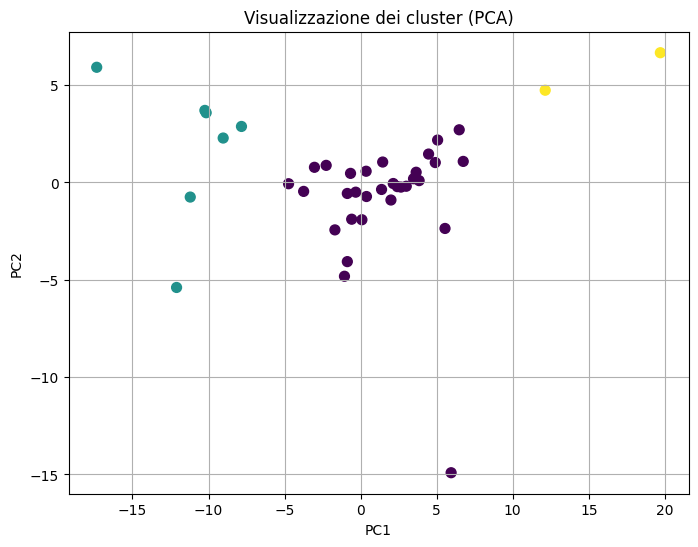

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Riduci a 2 dimensioni per lo scatter plot
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_scaled)

# Scatter plot colorato per cluster
plt.figure(figsize=(8, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis', s=50)
plt.title("Visualizzazione dei cluster (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()
